# Testing Visualization Methods for Planet Scenes

This notebook explores several methods for visualizing raw PlanetScope Analytic SR scenes as RGB images for use in image annotation and inspecting model results. Tests are applied to small image chips to see if the relative performance of different methods remains the same.

In [1]:
from IPython.display import Image
import rasterio
import skimage
import skimage.io as skio
import scipy
import os
import sys
import pathlib
import math
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from rasterio.plot import show
from osgeo import gdal

# Raw tiff directory
RAW_DIR = '../img/raw_tiffs'

## Setup

Let's define a few simple helper functions for our visualizations.

In [8]:
def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_max = arr.max()
    return arr / arr_max

def reorder_to_rgb(image):
    '''reorders planet bands to red, green, blue for imshow'''
    blue = image[:,:,0])
    green = image[:,:,1])
    red = image[:,:,2])
    return np.stack([red, green, blue], axis=-1)

def normalize_to_rgb(image):
    '''reorders planet bands to red, green, blue for imshow'''
    blue = normalize(image[:,:,0])
    green = normalize(image[:,:,1])
    red = normalize(image[:,:,2])
    return np.stack([red, green, blue], axis=-1)

def normalize_mb(image):
    '''normalize each band of multiband images'''
    for b in range(0,image.shape[2]):
        image[:,:,b] = normalize(image[:,:,b])
    return (image)

SyntaxError: invalid syntax (<ipython-input-8-41388fe4c82a>, line 8)

Get a sample of Planet GeoTiffs to use

In [3]:
# Get array of full Planet tiffs
tiffs = np.array(next(os.walk(RAW_DIR))[2])
# Take first two tiff files (skip .DS_Store file)
tiffs = tiffs[1:3]
print(tiffs)

# Read in tiffs
imgA = skio.imread(os.path.join(RAW_DIR,tiffs[0]))
imgB = skio.imread(os.path.join(RAW_DIR,tiffs[1]))

['20180331_141443_1010_3B_AnalyticMS_SR.tif'
 '20180409_014042_1015_3B_AnalyticMS_SR.tif']


Now let's calculate the 2nd and 98th percentiles of each image band for use later in contrast stretching

In [27]:
imgA_percs = []
imgB_percs = []

for b in range(0,3):
    ap2, ap98 = np.percentile(imgA[:,:,b], (2, 98))
    bp2, bp98 = np.percentile(imgA[:,:,b], (2, 98))

    imgA_percs.append([ap2, ap98])
    imgB_percs.append([bp2, bp98])

print(imgA_percs)

[[0.0, 529.0], [0.0, 713.0], [0.0, 766.0]]


## Visualizing Full Planet Scenes

Let's first visualize the images in their raw form without applying any color corrections

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


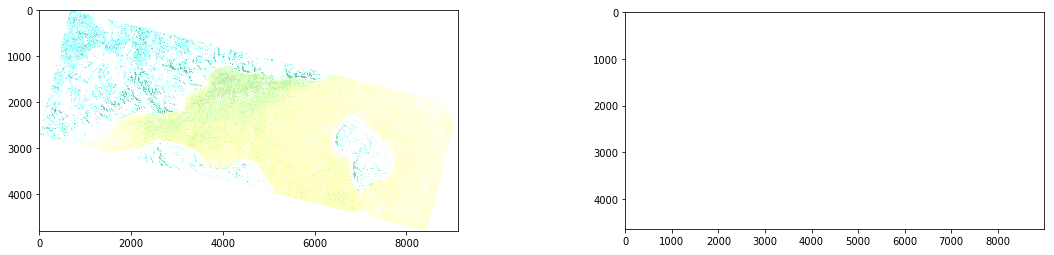

In [29]:
# Define size of plot
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over files and plot
for t in range(0,2):
    img = skio.imread(os.path.join(RAW_DIR,tiffs[t]))
    fig.add_subplot(1,2,t+1)
    plt.imshow(img, cmap='brg')

Clearly this doesn't work well because raw Planet scenes are 16-bit images with values up to approximately 65,000, well above the 8-bit limit of 255 used by `matplotlib`. 

So, let's now try visualizing the scenes after first normalizing all bands.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


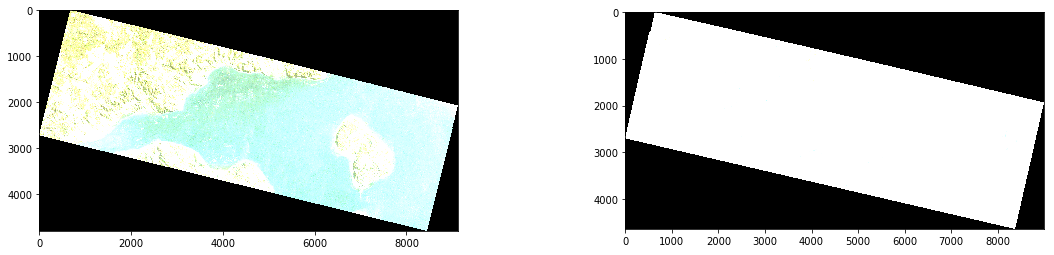

In [30]:
# Define size of plot
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over files and plot
for t in range(0,2):
    img = skio.imread(os.path.join(RAW_DIR,tiffs[t]))
    img = normalize_to_rgb(img)
    fig.add_subplot(1,2,t+1)
    plt.imshow(img)

Next let's apply histogram equalization to the normalized band

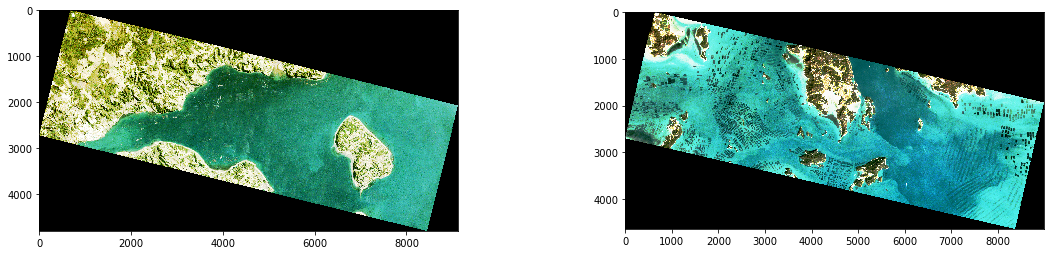

In [31]:
# Define size of plot
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over files and plot
for t in range(0,2):
    img = skio.imread(os.path.join(RAW_DIR,tiffs[t]))
    img = normalize_to_rgb(img)
    nd = img[:,:,1] > 0
    img = exposure.equalize_hist(img, mask = nd)
    fig.add_subplot(2,2,t+1)
    plt.imshow(img)

That looks better but the contrast is really intense. This time we'll try using adaptive histogram equalization to improve the local contrast.

/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


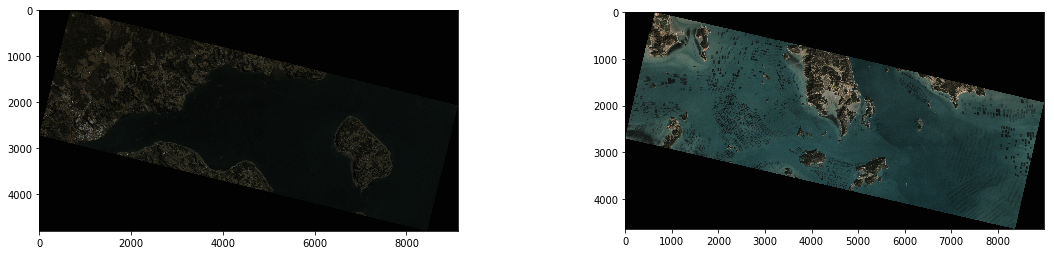

In [32]:
# Define size of plot
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over files and plot
for t in range(0,2):
    img = skio.imread(os.path.join(RAW_DIR,tiffs[t]))
    img = normalize_to_rgb(img)
    nd = img[:,:,1] > 0
    img = exposure.equalize_adapthist(img)
    fig.add_subplot(2,2,t+1)
    plt.imshow(img)

Not bad, but the brightness and contrast are very low. Lastly, let's apply a simple contrast stretching method.

In [35]:
# Define a contrast stretching algorithm for multiband images
def contrast_stretch_mb(img):
    # Loop over RGB bands
    for b in range(0,3):
        p2, p98 = np.percentile(img[:,:,b], (2, 98))
        img_scaled = exposure.rescale_intensity(img, in_range=(p2, p98))
        img[:,:,b] = img_scaled[:,:,b]
    return img

Test contrast stretching method

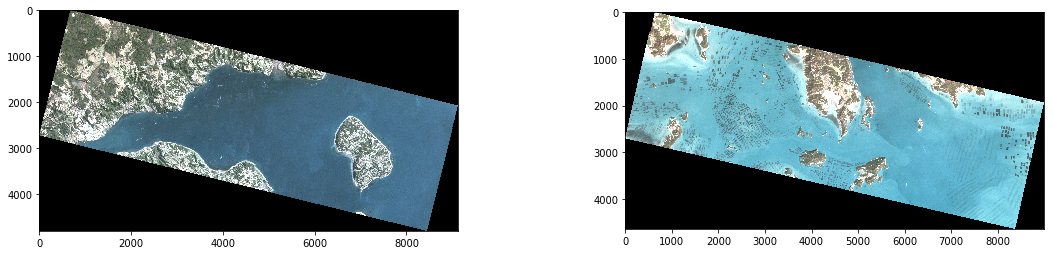

In [5]:
# Define size of plot
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over files and plot
for t in range(0,2):
    img = skio.imread(os.path.join(RAW_DIR,tiffs[t]))
    img = normalize_to_rgb(img)
    # Contrast stretching
    img = contrast_stretch_mb(img)
    fig.add_subplot(2,2,t+1)
    plt.imshow(img)

Uhhhh yes please.

## Save Color Corrected Images as PNGs
Save color corrected image chips as PNG files for labeling.

/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


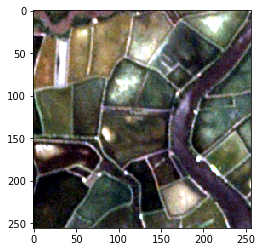

In [47]:
# Define a directory of chips to use for testing
CHIP_DIR = '../img/raw_tiffs/vis_test'

# Chip files
chips = os.listdir(CHIP_DIR)

# Loop over files and plot
for t in range(0,1):
    img = skio.imread(os.path.join(CHIP_DIR, chips[t]))
    img = reorder_to_rgb(img)
    img = contrast_stretch_mb(img)
    
    filename = CHIP_DIR + '/TEST_' + str(t) + '.png'
    plt.imshow(img)
    skio.imsave(filename, img)